# Simple Integrated Assessment Model (IAM) with Climate-Economy Tradeoffs
- This notebook implements a simple Integrated Assessment Model (IAM) based on the Solow-type growth model, extended to include climate change damages. - It incorporates climate damage and mitigation and solves for optimal savings and mitigation rates.
- It aims to find optimal **savings (economic policy)** and **emission mitigation (climate policy)** rates over time that maximize social welfare (utility of consumption), subject to economic and climate dynamics.
- A simple IAM that captures the trade-off between climate change and economic growth allows us to explore the optimal policy (savings rate and greenhouse gas reduction rate) and maximize the utility of that policy.

## Contents
1. Model Description and Mathematical Formulation
2. Optimization
3. Sensitivity Analysis

## 1. Model Description and Mathematical Formulation
**📐Model Features:**
- Cobb-Douglas production function: $Y = A K^α$
   - Simplifying the model by holding the working population (or labor supply) L constant and absorbing it into A allows for easier numerical computation and optimization of the model.
- Capital accumulation with depreciation
- Climate damage reduces usable output
- Emissions depend on mitigation efforts
- Objective: maximize discounted utility of consumption

We consider a simplified Solow growth model under climate constraints.

Let: 
- $K_t$: Capital stock at time t  
- $s_t$: Savings rate at time t (Allocation to capital formation for each year; Percentage to be transferred to capital stock in the next fiscal year)
- $\tau_t$: Mitigation rate at time t (Greenhouse gas reduction ratio for each year; e.g., carbon tax rate)
- $D_t = 1 - D_{coeff} × (1 - \tau_t)$: Climate damage rate at time t (increases over time)
- $A_t$: Productivity (exogenous Total Factor Productivity (TFP)) A larger A means more total production, more consumption and reduced investment.
- $Y_t = (1-D_t)(1-\tau_t)A_t K_t^\alpha$: Output (Total amount of goods and services produced by the economy in a given year) at time t
- $C_t = (1 - s_t) Y_t$: Consumption at time t (Production minus savings and climate damage)
- $E_t = (1 - \tau_t)Y_t × ε$: Emissions at time $t$ ($ε$ is emission coefficient)
- $Y_t^{net}=Y_t(1-D_t)$: Net Output (Actual production considering climate damage). This is allocated to consumption and savings, which ultimately affects utility.

### 🎯 Objective Function

Maximize social welfare (the discounted sum of utility from consumption over time):

$$
\max_{\\{s_t, \tau_t\\}} \sum_{t=0}^{T} \frac{1}{(1 + \rho)^t} \cdot \frac{C_t^{1 - \theta}}{1 - \theta}
$$

subject to capital dynamics:

- Capital accumulation:  
  $$
  K_{t+1} = (1 - \delta)K_t + s_t \cdot Y_t
  $$

- Consumption:  
  $$
  C_t = (1 - s_t) \cdot Y_t
  $$

- Bounds:  
  $$
  0 \leq s_t, \tau_t \leq 1
  $$


### Notes 
- Discounting
$\frac{1}{(1 + \rho)^t}$: Evaluate future utility in terms of present value. ρ is the discount factor rate, the degree of emphasis on the present over the future.
- Utility function $\frac{C_t^{1 - \theta}}{1 - \theta}$: Typical CRRA (Constant Relative Risk Aversion) type utility function. If Relative Risk Averseness $\theta=1$, then $\log C_t$
- $\delta$: Depreciation rate of capital
- $Y_t = (1 - D_t)(1 - \tau_t) A K_t^{\alpha}$
  - $AK^\alpha$: Potential output
  - $(1-D_t)$: Attenuation factor for climate damage (Damage caused by emissions reduces productivity.)
  - $(1-\tau_t)$: Economic Cost of Carbon Taxes (The introduction of a carbon tax will curb economic activity.)

In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Time horizon
T = 30
alpha = 0.3 # production elasticity of capital: the larger α, the greater the role of capital and the more efficient the saving.
delta = 0.1
rho = 0.03

# Exogenous variables
A = np.array([1.002**t for t in range(T+1)]) 
D = np.array([0.002 * t for t in range(T+1)])
K0 = 1.0

# Objective function
def model_objective(x):
    s = x[:T+1]
    tau = x[T+1:]
    K = np.zeros(T+1)
    C = np.zeros(T+1)
    K[0] = K0
    for t in range(T):
        Y = (1 - D[t]) * (1 - tau[t]) * A[t] * K[t]**alpha
        C[t] = (1 - s[t]) * Y
        K[t+1] = (1 - delta) * K[t] + s[t] * Y
    Y = (1 - D[T]) * (1 - tau[T]) * A[T] * K[T]**alpha
    C[T] = (1 - s[T]) * Y
    if np.any(C <= 0):
        return 1e6  # penalty
    return -np.sum((1 / (1 + rho) ** np.arange(T+1)) * np.log(C))

## 2. Optimization
Optimize $s_t$ and $\tau_t$

In [2]:
x0 = np.array([0.3] * (T+1) + [0.1] * (T+1))
bounds = [(0, 1)] * (2 * (T+1))
result = minimize(model_objective, x0, bounds=bounds, method='SLSQP')
s_opt = result.x[:T+1]
tau_opt = result.x[T+1:]

In [3]:
# Plotting results
K = np.zeros(T+1)
C = np.zeros(T+1)
K[0] = K0
for t in range(T):
    Y = (1 - D[t]) * (1 - tau_opt[t]) * A[t] * K[t]**alpha
    C[t] = (1 - s_opt[t]) * Y
    K[t+1] = (1 - delta) * K[t] + s_opt[t] * Y
Y = (1 - D[T]) * (1 - tau_opt[T]) * A[T] * K[T]**alpha
C[T] = (1 - s_opt[T]) * Y

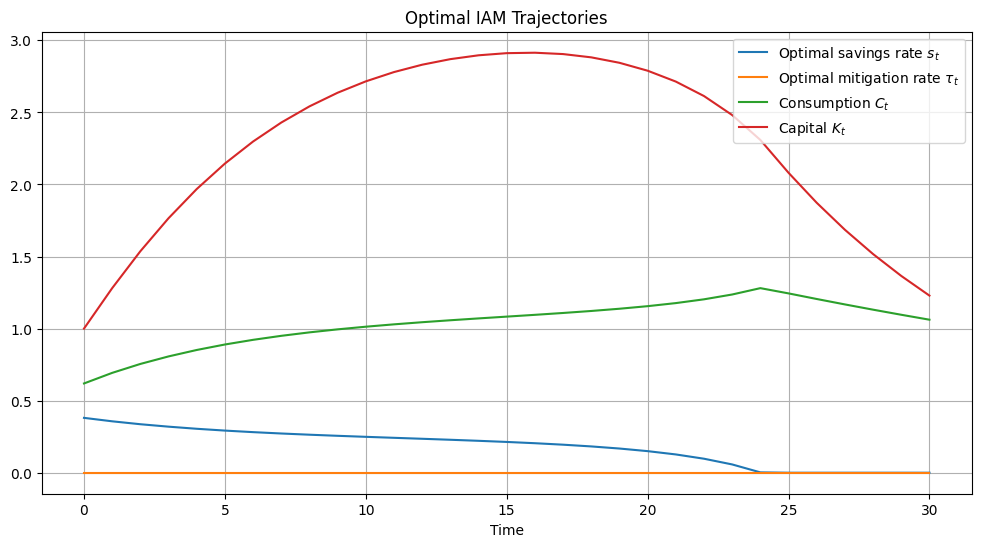

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(s_opt, label='Optimal savings rate $s_t$')
plt.plot(tau_opt, label='Optimal mitigation rate $\\tau_t$')
plt.plot(C, label='Consumption $C_t$')
plt.plot(K, label='Capital $K_t$')
plt.xlabel('Time')
plt.title('Optimal IAM Trajectories')
plt.legend()
plt.grid(True)
plt.show()

## 🔍 3. Sensitivity Analysis

We explore how the optimal utility outcome is affected by changes in key model parameters:

- **α**: Elasticity of output with respect to capital (capital intensity)
- **A**: Total Factor Productivity (TFP)

This helps us evaluate:
- The robustness of our optimal solution
- Which parameters have the most influence on welfare outcomes
- Where uncertainties in economic assumptions may lead to different policy prescriptions

The result is visualized as a heatmap showing how utility changes across combinations of α and A.

In [5]:
# Sensitivity analysis
rhos = [0.01, 0.03, 0.05]
D_multipliers = [0.5, 1.0, 1.5]
results = {}
for rho_test in rhos:
    for D_mult in D_multipliers:
        D_sens = D_mult * np.array([0.01 * t for t in range(T+1)])
        def model_obj_sens(x):
            s = x[:T+1]
            tau = x[T+1:]
            K = np.zeros(T+1)
            C = np.zeros(T+1)
            K[0] = K0
            for t in range(T):
                Y = (1 - D_sens[t]) * (1 - tau[t]) * A[t] * K[t]**alpha
                C[t] = (1 - s[t]) * Y
                K[t+1] = (1 - delta) * K[t] + s[t] * Y
            Y = (1 - D_sens[T]) * (1 - tau[T]) * A[T] * K[T]**alpha
            C[T] = (1 - s[T]) * Y
            if np.any(C <= 0):
                return 1e6
            return -np.sum((1 / (1 + rho_test) ** np.arange(T+1)) * np.log(C))

        result_sens = minimize(model_obj_sens, x0, bounds=bounds, method='SLSQP')
        s_sens = result_sens.x[:T+1]
        tau_sens = result_sens.x[T+1:]
        results[(rho_test, D_mult)] = (s_sens, tau_sens)

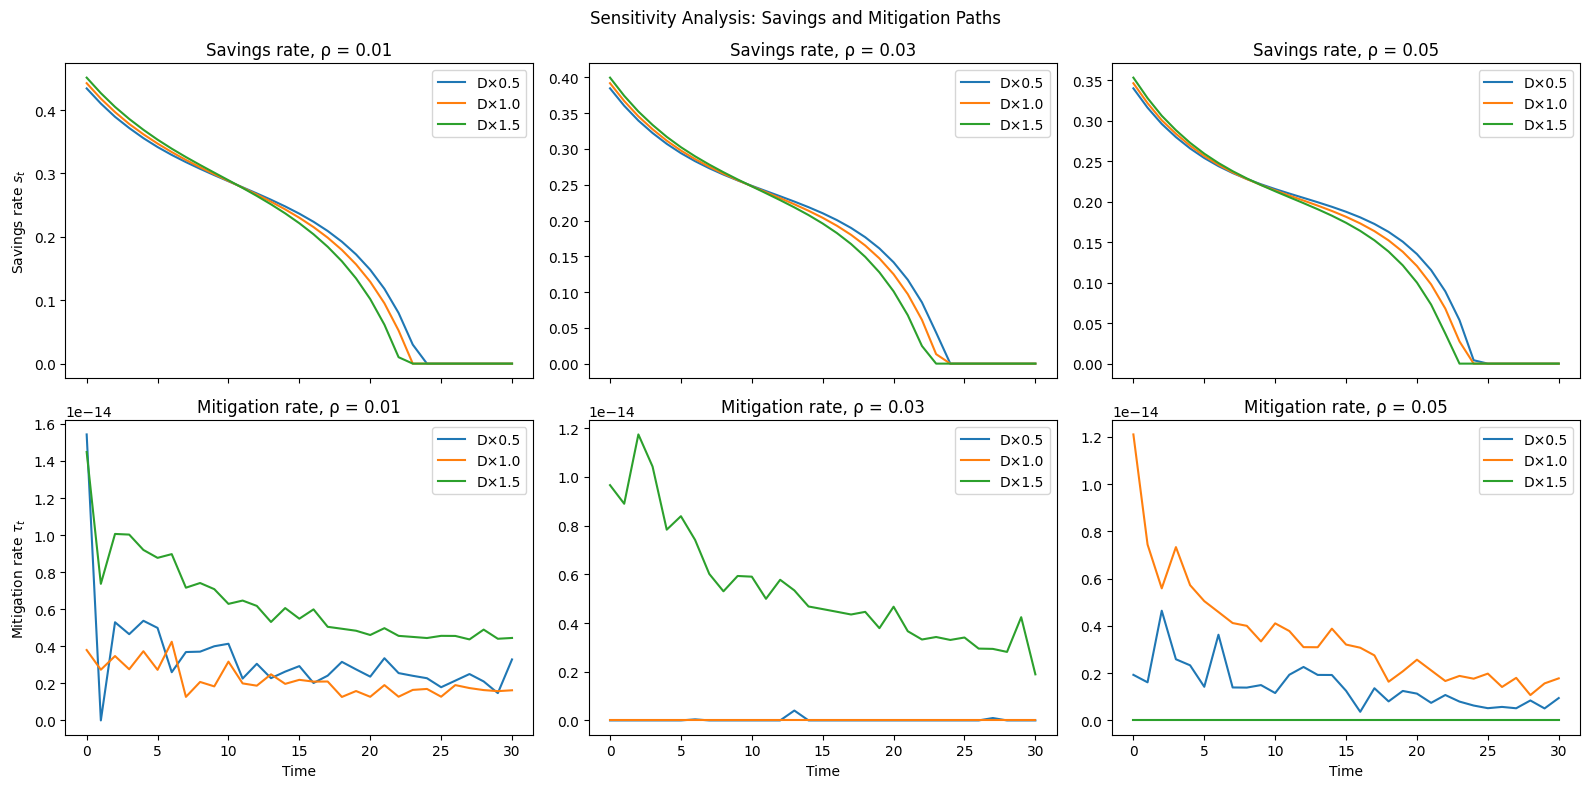

In [6]:
# Plotting sensitivity results
fig, axes = plt.subplots(2, len(rhos), figsize=(16, 8), sharex=True)
for i, rho_test in enumerate(rhos):
    for D_mult in D_multipliers:
        s_plot, tau_plot = results[(rho_test, D_mult)]
        axes[0, i].plot(s_plot, label=f"D×{D_mult}")
        axes[1, i].plot(tau_plot, label=f"D×{D_mult}")

    axes[0, i].set_title(f"Savings rate, ρ = {rho_test}")
    axes[1, i].set_title(f"Mitigation rate, ρ = {rho_test}")
    # axes[0, i].set_ylim(0, 1)
    # axes[1, i].set_ylim(0, 1)
    axes[1, i].set_xlabel("Time")
    axes[0, i].legend()
    axes[1, i].legend()
axes[0, 0].set_ylabel("Savings rate $s_t$")
axes[1, 0].set_ylabel("Mitigation rate $\\tau_t$")
plt.suptitle("Sensitivity Analysis: Savings and Mitigation Paths")
plt.tight_layout()
plt.show()

We conduct sensitivity analysis over production parameters (α, A) and visualize the results.

In [7]:
T = 30 
initial_saving_rate = 0.2
initial_mitigation_rate = 0.1

original_params = {
    'alpha': 0.3,
    'A': 1.5,
    'delta': 0.1,
    'rho':0.03,
    'theta': 1.5,
    'D_coeff': 0.002
}

# optimize [s_0, s_1, ..., s_T-1, mu_0, mu_1, ..., mu_T-1]
initial_guess = np.array([initial_saving_rate] * T + [initial_mitigation_rate] * T)

# constraints
bounds = [(0.01, 0.99)] * T + [(0.0, 1.0)] * T

# total emissions
def emission_constraint(x, params):
    _, emissions, _, _ = simulate_model(x, params)
    total_emissions = np.sum(emissions)
    return 50.0 - total_emissions  # 50 is example of emission limit

cons = ({
    'type': 'ineq',
    'fun': lambda x, p=original_params: emission_constraint(x, p)
},)


In [8]:
def simulate_model(x, params, T=30):
    """
    Simulate the model and return capital, emissions, consumption, and utility series
    x: Optimized variable vector (length 2T) [savings_0...savings_T-1, mitigation_0...mitigation_T-1]
    params: parameter dictionary
    T: Period (Default: 30 years)
    """
    s = x[:T]    # savings rate series
    mu = x[T:]   # reduction rate series

    # parameter expansion
    alpha = params['alpha']
    A = params['A']
    delta = params['delta']
    rho = params['rho']
    theta = params['theta']
    D_coeff = params['D_coeff']

    # Initial valeus
    K = np.zeros(T+1)
    Y = np.zeros(T)
    C = np.zeros(T)
    emissions = np.zeros(T)
    U = np.zeros(T)

    K[0] = 1.0  # Initial capital

    for t in range(T):
        Y[t] = A * K[t]**alpha
        damages = 1.0 - D_coeff * (1 - mu[t])  # Simplified model of damage rate
        damages = max(0.0, min(damages, 1.0))  # Restricted to 0 to 1
        emissions[t] = (1 - mu[t]) * Y[t] * 0.1  # Discharge = activity x discharge coefficient (0.1)
        C[t] = max(1e-6, (1 - s[t]) * Y[t] * damages)
        U[t] = (C[t]**(1 - theta)) / (1 - theta)
        if t < T - 1:
            K[t+1] = (1 - delta) * K[t] + s[t] * Y[t]

    # discount utility
    discount_factors = 1 / ((1 + rho) ** np.arange(T))
    total_utility = np.sum(discount_factors * U)

    return K, emissions, C, total_utility


In [9]:
def objective(x, params):
    _, _, _, utility = simulate_model(x, params)
    return -utility  # Take a minus to maximize

C:\Users\user\anaconda3\envs\simple_iam\Lib\site-packages\scipy\optimize\_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
C:\Users\user\anaconda3\envs\simple_iam\Lib\site-packages\scipy\optimize\_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
C:\Users\user\anaconda3\envs\simple_iam\Lib\site-packages\scipy\optimize\_slsqp_py.py:499: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])


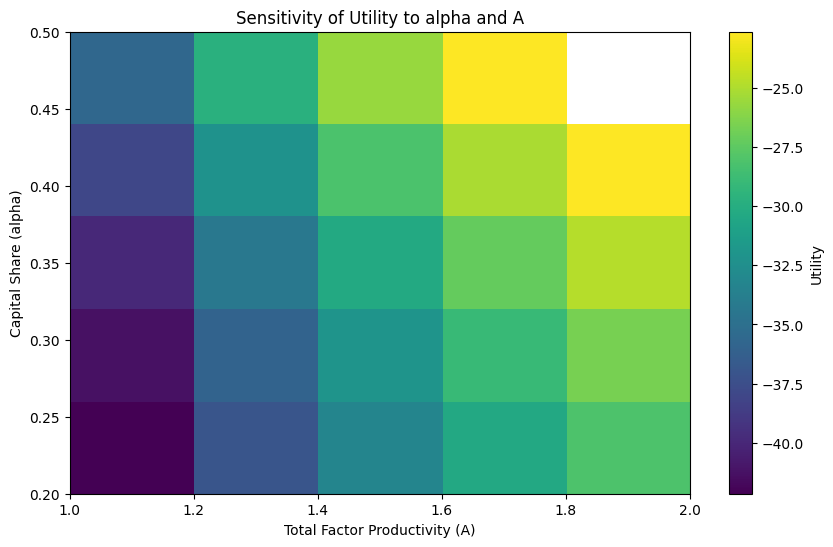

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 

# parameter
alpha_values = np.linspace(0.2, 0.5, 5)
A_values = np.linspace(1.0, 2.0, 5)

# results
utility_grid = np.zeros((len(alpha_values), len(A_values)))

# original parameters
original_params = {
    'alpha': 0.3,
    'A': 1.5,
    'delta': 0.1,
    'rho': 0.03,
    'theta': 1.5,
    'D_coeff': 0.002
}

# memorizing optimum and utility
for i, alpha in enumerate(alpha_values):
    for j, A in enumerate(A_values):
        params = original_params.copy()
        params['alpha'] = alpha
        params['A'] = A

        cons = ({
            'type': 'ineq',
            'fun': lambda x, p=params: emission_constraint(x, p)
        },)

        result = minimize(
            objective,
            initial_guess,
            args=(params,),
            method='SLSQP',
            bounds=bounds,
            constraints=cons
        )

        if result.success:
            utility_grid[i, j] = -result.fun  # invert to maximize
        else:
            utility_grid[i, j] = np.nan  # NaN if no solution

# visualzie heatmap
plt.figure(figsize=(10, 6))
im = plt.imshow(utility_grid, origin='lower', aspect='auto',
                extent=[A_values[0], A_values[-1], alpha_values[0], alpha_values[-1]],
                cmap='viridis')
plt.colorbar(im, label='Utility')
plt.xlabel('Total Factor Productivity (A)')
plt.ylabel('Capital Share (alpha)')
plt.title('Sensitivity of Utility to alpha and A')
plt.grid(False)
plt.show()


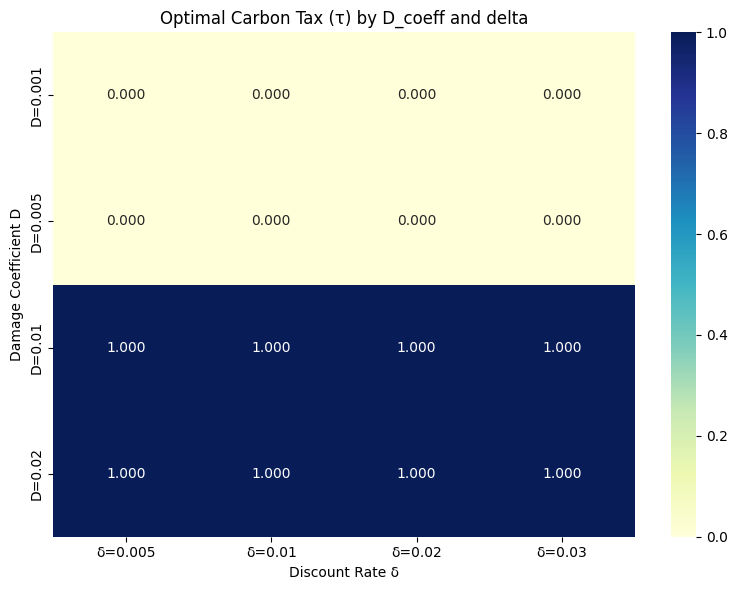

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# === Model definition ===
def simulate_model(K0, params, years):
    alpha, A, theta, D_coeff, delta = params['alpha'], params['A'], params['theta'], params['D_coeff'], params['delta']
    tau = params['tau']  # initial value
    E = params['E0']
    K = K0
    outputs = []

    for t in range(years):
        D_t = D_coeff * (E ** 2)  # damage function
        Y = (1 - D_t) * (1 - tau) * A * (K ** alpha)
        outputs.append((tau, Y))
        K += 0.1 * Y  # simplified capital accumulation
        E *= 1.01     
    
    return outputs

# === Objective function ===
def objective(tau, K0, params, years):
    params = params.copy()
    params['tau'] = tau[0]
    outputs = simulate_model(K0, params, years)
    discounted_Y = sum((Y / ((1 + params['delta']) ** t)) for t, (_, Y) in enumerate(outputs))
    return -discounted_Y 

# === Parameters setting ===
years = 30
K0 = 10.0
alpha = 0.3
A = 1.5
theta = 1.5
E0 = 10.0

# sensitivity analysis axes
D_coeff_list = [0.001, 0.005, 0.01, 0.02]
delta_list = [0.005, 0.01, 0.02, 0.03]

results = {}

for D_coeff in D_coeff_list:
    for delta in delta_list:
        params = {
            'alpha': alpha,
            'A': A,
            'theta': theta,
            'D_coeff': D_coeff,
            'delta': delta,
            'E0': E0,
            'tau': 0.1
        }

        res = minimize(objective, x0=[0.1], args=(K0, params, years), bounds=[(0.0, 1.0)])
        optimal_tau = res.x[0]
        outputs = simulate_model(K0, {**params, 'tau': optimal_tau}, years)
        Y_series = [Y for _, Y in outputs]
        results[(D_coeff, delta)] = {
            'tau': optimal_tau,
            'Y': Y_series
        }

# === optimal carbon tax heatmap ===
import seaborn as sns
import pandas as pd

tau_matrix = np.zeros((len(D_coeff_list), len(delta_list)))

for i, D_coeff in enumerate(D_coeff_list):
    for j, delta in enumerate(delta_list):
        tau_matrix[i, j] = results[(D_coeff, delta)]['tau']

df = pd.DataFrame(tau_matrix, index=[f"D={d}" for d in D_coeff_list], columns=[f"δ={d}" for d in delta_list])

plt.figure(figsize=(8, 6))
sns.heatmap(df, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("Optimal Carbon Tax (τ) by D_coeff and delta")
plt.xlabel("Discount Rate δ")
plt.ylabel("Damage Coefficient D")
plt.tight_layout()
plt.show()

## 📈 Possible Extensions

- Incorporate temperature feedbacks from emissions (simple climate module)
- Add carbon pricing mechanisms or abatement cost functions
- Use stochastic optimization to reflect uncertainty
- Visualize paths of emissions, output, consumption
- Build a Streamlit dashboard for interaction